In [ ]:
# importing the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
# Reading the input
data = pd.read_csv('/content/gdrive/MyDrive/Sample-data/pubg.csv')
data.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,0,0,0.00,1306,squad-fpp,28,26,-1,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,0,0,0.00,1777,squad-fpp,26,25,1484,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,0,0,0.00,1318,duo,50,47,1491,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,0,0,0.00,1436,squad-fpp,31,30,1408,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,1,1,58.53,1424,solo-fpp,97,95,1560,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [ ]:
data.dropna(inplace=True)
print(data.shape)

(4446965, 29)


# Outlaiers Detection

- Kills without moving is not possible in game so lets check if there are any records with zero moment and have kills

In [1]:
# Create feature totalDistance
data['totalDistance'] = data['rideDistance'] + data['walkDistance'] + data['swimDistance']
# Create feature killsWithoutMoving
data['killsWithoutMoving'] = ((data['kills'] > 0) & (data['totalDistance'] == 0))

NameError: ignored

In [ ]:
# See wheather there are players with kills and no movement
display(data[data['killsWithoutMoving'] == True].shape)
data[data['killsWithoutMoving'] == True].head()

In [ ]:
# Remove these data's as they are invalid or outlaiers
data.drop(data[data['killsWithoutMoving'] == True].index, inplace=True)

In [ ]:
data.shape

In [ ]:
# Players with more road kills in a single match is not most likely to happen lets check for those data
r_kill = data[data['roadKills'] > 10]
print(r_kill.shape)
r_kill

- looks like this data is ok.
- but player with id c3e444f7d1289f has ride distance 5m and road kills 14 so its naturally not possible 

In [ ]:
#creating new feature r_kill to find outlaiers
data['r_kill'] = ((data['roadKills'] > 10) & (data['rideDistance'] < 0.100))
print(data[data['r_kill'] == True].shape)
data[data['r_kill']==True].head()

In [ ]:
# removing the outlaier in road kills
data.drop(data[data['r_kill'] == True].index, inplace=True)
data.shape

- plotting data with kill counts

In [ ]:
sns.catplot(x=data['kills'],data=data,aspect=3,kind='count')

- have a closer look above max kill counts a player has is around 15.
- but players more than that can be considered as outlaiers so we set limit to 30 kills a player can have.

In [ ]:
# Players with more than 30 kills
display(data[data['kills'] > 30].shape)
data[data['kills'] > 30].head(10)

In [ ]:
# removing these outlaiers
data.drop(data[data['kills'] > 30].index, inplace = True)
data.shape

In [ ]:
# Create headshot_rate feature
data['headshot_rate'] = data['headshotKills'] / data['kills']
data['headshot_rate'] = data['headshot_rate'].fillna(0)

In [ ]:
print(data.shape)
data.head()

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(data['headshot_rate'])
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
sns.boxplot(data['headshot_rate'])
plt.show()

In [ ]:
# Players who have head shot kills 100% means, kills = head shot kills
print(data[(data['headshot_rate'] == 1) & (data['kills'] > 9)].shape)
data[(data['headshot_rate'] == 1) & (data['kills'] > 9)].head()

- some players might be good players and have all head shots so lets keep these data

In [ ]:
# Plot of longestKill
plt.figure(figsize=(12,4))
sns.distplot(data['longestKill'])
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
sns.boxplot(data['longestKill'])
plt.show()

In [ ]:
# players with kills with distance more than 1 km
print(data[data['longestKill'] >= 1000].shape)
data[data['longestKill'] >= 1000].head()

- I think more than 1000mt is highly outlaiered so removing them

In [ ]:
data.drop(data[data['longestKill'] >= 1000].index, inplace = True)
data.shape

In [ ]:
# Plot of the weaponsAcquired
plt.figure(figsize=(12,4))
sns.distplot(data['weaponsAcquired'])
plt.show()

In [ ]:
# Plot of the weaponsAcquired
plt.figure(figsize=(12,4))
sns.boxplot(data['weaponsAcquired'])
plt.show()

- from above graph its clear that most of players have less than 20 weapons acquired so we can remove outlaiers in this
- even thouhg after 20 all are outlaiers and as its dense till 50, we set limit 45 and lets see data

In [ ]:
# Players who acquired more than 45 weapons
print(data[data['weaponsAcquired'] >= 45].shape)
data[data['weaponsAcquired'] >= 45].head()

In [ ]:
# dropping players with weapon acquired more than 45
data.drop(data[data['weaponsAcquired'] >= 45].index, inplace = True)
data.shape

In [ ]:
# plot of heals used by players
plt.figure(figsize=(12,4))
sns.distplot(data['heals'])
plt.show()

In [ ]:
plt.figure(figsize=(12,4))
sns.boxplot(data['heals'])
plt.show()

- According to above graphs heals used by most of the players is 5 so above that are outlaiers, we set limit to 35

In [ ]:
print(data[data['heals'] >= 35].shape)
data[data['heals'] >= 35].head()

In [ ]:
# dropping the outlaiers in heals
data.drop(data[data['heals'] >= 35].index, inplace = True)
data.shape

# Encoding

In [ ]:
# Encoding the match type feature
from sklearn.preprocessing import LabelEncoder
enc=LabelEncoder()
data.matchType = enc.fit_transform(data.matchType)
data.matchType.unique()

array([15,  2, 13, 14,  3, 12, 11,  0,  5,  9,  4,  7,  6, 10,  1,  8])

- Categorical encoding on match id and group id so they help in decission tree of Random Forest

In [ ]:
# Turn groupId and match Id into categorical types
data['groupId'] = data['groupId'].astype('category')
data['matchId'] = data['matchId'].astype('category')

# Get category coding for groupId and matchID
data['groupId_cat'] = data['groupId'].cat.codes
data['matchId_cat'] = data['matchId'].cat.codes

# Get rid of old columns
data.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
data[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,613585,30085
1,827575,32751
2,843264,3143
3,1340075,45259
4,1757347,20531


In [ ]:
# dropping ID column as not required
data.drop(columns=['Id'],axis=1,inplace=True)

In [ ]:
# Importing necessary package for modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

In [ ]:
data.corrwith(data['winPlacePerc'])

assists               0.301030
boosts                0.634472
damageDealt           0.444135
DBNOs                 0.280789
headshotKills         0.280171
heals                 0.430257
killPlace            -0.719277
killPoints            0.012958
kills                 0.424338
killStreaks           0.377838
longestKill           0.410768
matchDuration        -0.005104
matchType            -0.028494
maxPlace              0.037565
numGroups             0.039831
rankPoints            0.013499
revives               0.241009
rideDistance          0.343004
roadKills             0.034699
swimDistance          0.149654
teamKills             0.015989
vehicleDestroys       0.073456
walkDistance          0.811269
weaponsAcquired       0.597213
winPoints             0.007090
winPlacePerc          1.000000
totalDistance         0.677329
killsWithoutMoving         NaN
r_kill                     NaN
headshot_rate         0.181030
groupId_cat           0.000433
matchId_cat           0.000194
dtype: f

# Taking Some Sample

In [ ]:
# Take sample for easy modeling and understanding
sample = 1050000
data_sample = data.sample(sample)

# Splitting Data into Train And Test

In [2]:
# splitting up of data
X = data_sample.loc[ : ,['assists','boosts','damageDealt','DBNOs','headshotKills','heals','killPlace', 'killPoints','kills',
                  'killStreaks','longestKill','matchDuration', 'matchType','maxPlace','numGroups','rankPoints','swimDistance'
                  ,'revives','roadKills', 'teamKills','vehicleDestroys','weaponsAcquired','winPoints','walkDistance','rideDistance']] 
y = data_sample.loc[ : ,['winPlacePerc']] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NameError: ignored

In [3]:
X_train.shape,X_test.shape

NameError: ignored

# Random Forest

In [4]:
model = RandomForestRegressor()
model.fit(X_train,y_train)
y_predict=model.predict(X_test)
print(r2_score(y_test,y_predict))
print(mean_absolute_error(y_test,y_predict))
print(mean_squared_error(y_test,y_predict))

NameError: ignored

In [5]:
model = RandomForestRegressor(n_estimators=100,min_samples_leaf=7)
model.fit(X_train,y_train)
y_predict=model.predict(X_test)
print(r2_score(y_test,y_predict))
print(mean_absolute_error(y_test,y_predict))
print(mean_squared_error(y_test,y_predict))

NameError: ignored

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)
y_predict=model.predict(X_test)
print(r2_score(y_test,y_predict))
print(mean_absolute_error(y_test,y_predict))
print(mean_squared_error(y_test,y_predict))

0.8330860744880397
0.09171810697570594
0.015790525097856015


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


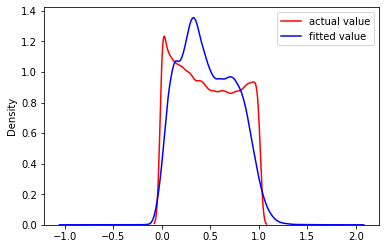

In [ ]:
ax1=sns.distplot(y_test,hist=False,color='red',label="actual value")
sns.distplot(y_predict,hist=False,color='b',label="fitted value")
plt.legend(loc='upper right')

# XGBoost

In [ ]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train,y_train)
y_predict=model.predict(X_test)
print(r2_score(y_test,y_predict))
print(mean_absolute_error(y_test,y_predict))
print(mean_squared_error(y_test,y_predict))

[10:31:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.8992642772943183
0.06915818318476066
0.009500709900110564


# ANN

In [ ]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor()
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
print(r2_score(y_test,y_predict))
print(mean_absolute_error(y_test,y_predict))
print(mean_squared_error(y_test,y_predict))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8779022022398265
0.07811761537402036
0.011495027213278428


In [ ]:
model = MLPRegressor(hidden_layer_sizes=(100,50,30))
model.fit(X_train,y_train)
y_predict = model.predict(X_test)
print(r2_score(y_test,y_predict))
print(mean_absolute_error(y_test,y_predict))
print(mean_squared_error(y_test,y_predict))

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9124140343407156
0.06609641259509176
0.008245874022497312


# CNN

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
# Data Modeling
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape = [25], activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'linear')  
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
model.summary()
model.fit(X_train, y_train, epochs=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2

In [ ]:
train_predict = model.predict(X_train)
train_msq = mean_squared_error(y_train, train_predict)
train_r2 = r2_score(y_train, train_predict)
print("Train:\nMean Squared Error :", train_msq, "\nR2 score :", train_r2)

test_predict = model.predict(X_test) 
test_msq = mean_squared_error(y_test, test_predict) 
test_r2 = r2_score(y_test, test_predict) 
print("\nTest:\nMean Squared Error :", test_msq, "\nR2 score :", test_r2)

Train:
Mean Squared Error : 0.007968494707215673 
R2 score : 0.9158026977705536

Test:
Mean Squared Error : 0.00802764568665492 
R2 score : 0.9151581950535139
